## implementation of Constrained Least Squares Filter based on noise parameters

## Motion degradation

### importing necessary libraries

In [1]:
from skimage.metrics import structural_similarity
import math
import cv2
import numpy as np
from matplotlib import pyplot as plt
from skimage.util import random_noise
from numpy import linalg as LA

### Reading image

In [2]:
img = cv2.imread('cover_book.tif',0)
img = cv2.resize(img,(525 , 525))
img = cv2.normalize(img, None, 0, 1.0, cv2.NORM_MINMAX, dtype=cv2.CV_64F)

### Defining discrete fourier transform function

In [3]:
def dftuv(M, N) :        
    u =np.linspace(0, M-1,M)
    v =np.linspace(0, N-1,N)       
    idx = np.where(u > M/2)
    u[idx] = u[idx] - M
    idy = np.where(v > N/2)
    v[idy] = v[idy] - N       
    V, U = np.meshgrid(v, u)    
    return V,U

### Fourier transform of image

In [4]:
f = np.fft.fft2(img)
mag = np.abs(f)
ang = np.angle(f)
magnitude_spectrum = 20*np.log(np.abs(f))
m,n = f.shape 
v = np.linspace(1,m,m )
u = np.linspace(1,n,n )
v,u=np.meshgrid(u,v)

### Defining degradation function

In [5]:
a=0.06
b=0
c=np.pi*(u*a+v*b)
T=1
H_motion = (T/c) *np.sin(c)*np.exp(-1j*c)
HF_motion =np.multiply(f, H_motion)
h_conv_f = np.real (np.fft.ifft2(HF_motion))

### Add gaussian noise with zero mean and var=0.1

In [6]:
noise=np.zeros((525,525),dtype=np.float64)
noise=cv2.randn(noise,0,0.1)
noise_freq = np.fft.fft2(noise)
G_freq =noise_freq + HF_motion

### Degraded image

In [7]:
noise_motion_space = np.real (np.fft.ifft2(G_freq))

### Laplacian kernel

In [8]:
p = np.array([  [0 ,-1, 0] , [-1,4,-1] , [0,-1,0]  ]  )
p_pad = np.pad(p, (261,261), 'constant')   
p_f = np.fft.fft2(p_pad )
mag = np.abs(p_f)
ang = np.angle(p_f)

### Initializing  $ \gamma $  and restored image

In [9]:
gamma=0;
clsf_f =  (np.conj(H_motion)) /( (  (np.abs(H_motion))**2 ) +gamma*(np.abs(p_f))**2 )
filtered_in_f  = clsf_f*G_freq 

### Initializing $||r||^2$ value

In [10]:
r_f = G_freq - np.multiply(filtered_in_f, H_motion)      
r= np.real(np.fft.ifft2(r_f))       
norm_noise = 525*525*(0.1**2)
norm= (LA.norm(r) )**2

## Finding best $ \gamma $ value until $ ||r||^2 = |\eta|^2 ± \alpha $ satisfied

In [11]:
while norm_noise - 0.001 >= norm :
    gamma += 0.1
    clsf_f=  (np.conj(H_motion)) /( (  (np.abs(H_motion))**2 ) +gamma*(np.abs(p_f))**2    )
    filtered_in_f  = clsf_f*G_freq 
    r_f = G_freq - np.multiply(filtered_in_f, H_motion)           
    r= np.real(np.fft.ifft2(r_f))     
    norm_noise = 525*525*(0.1**2)
    norm = (LA.norm(r) )**2

### Reported values

In [12]:
print("gamma = " , gamma , "\n||r||^2 = " ,norm ,  "\n||noise||^2 = ",norm_noise )

gamma =  5.399999999999997 
||r||^2 =  2756.4529537434073 
||noise||^2 =  2756.2500000000005


### Obtaining image in spatial domain (inverse fourier transform)

In [13]:
filtered_in_s = np.real (np.fft.ifft2(filtered_in_f))
filtered_in_s = cv2.normalize(filtered_in_s, None, 0, 1.0, cv2.NORM_MINMAX, dtype=cv2.CV_64F)
filtered_in_s_8bit = cv2.normalize(filtered_in_s, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)

### Calculating MSSIM and PSNR

In [14]:
(score, diff) = structural_similarity(img, filtered_in_s,data_range=img.max() - img.min(), full=True)
psnr = cv2.PSNR(img, filtered_in_s)

In [15]:
print("PSNR = " , psnr , "\nMSSIM = " ,score )

PSNR =  63.61189908682144 
MSSIM =  0.5665622959024331


## Figures

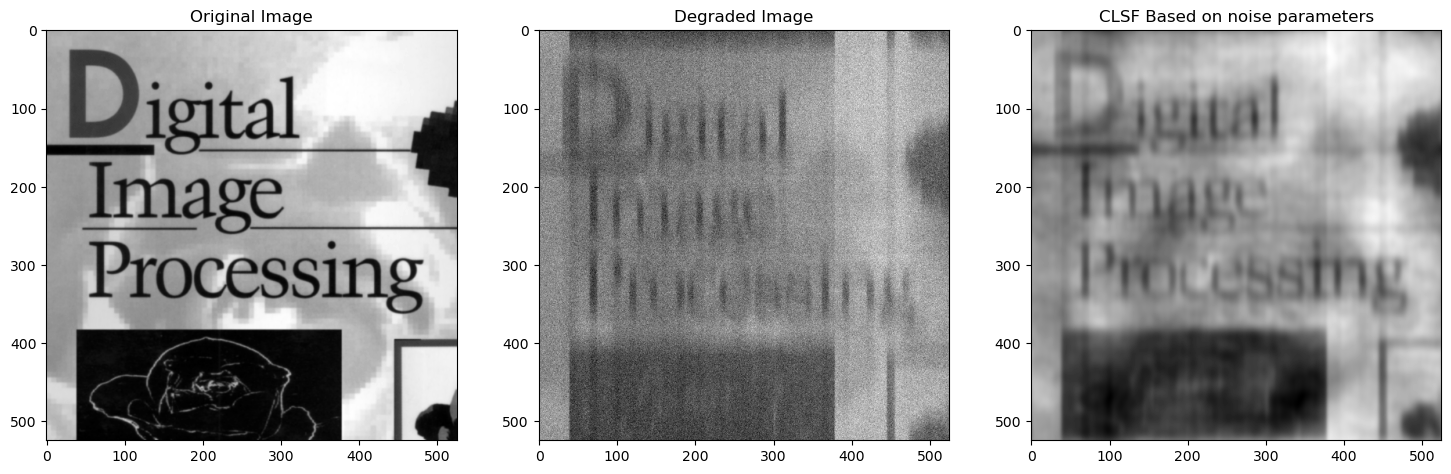

In [18]:
fig2 = plt.figure (figsize = (18,18))
ax1 = fig2.add_subplot (1,3,1)
ax1.imshow(img , cmap = 'gray')
ax1.title.set_text ('Original Image')

ax2 = fig2.add_subplot (1,3,2)
ax2.imshow (noise_motion_space , cmap = 'gray')
ax2.title.set_text ('Degraded Image')

ax3= fig2.add_subplot (1,3,3)
ax3.imshow (filtered_in_s , cmap='gray')
ax3.title.set_text('CLSF Based on noise parameters')